In [41]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal
from scipy.signal import savgol_filter
# import plotly.graph_objects as go
import matplotlib

matplotlib.rcParams.update({'font.size': 5})
matplotlib.rcParams['lines.linewidth'] = 0.5


In [71]:
def add_vTlabel():
    plt.xlabel("Velocity [Km/s]")
    plt.ylabel("Temperature [Kelvin]") 
def new_vT():
    matplotlib.rcParams.update({'font.size': 5})
    plt.figure(1, figsize = (5,2.5), dpi = 500)

In [42]:
coor_array=[]

long_coord = []
lat_coord = []

for i in range(2):
    long_coord.append(180*i)
for k in range(7):
    lat_coord.append(-15*k)

for lat in lat_coord:
    for long in long_coord:
        
        coor_array.append((long,lat))

In [43]:
width=np.load("widths.npy")

In [44]:
sample_data = np.asarray(np.genfromtxt('../GS4/GS4_Trace{}'.format(1), dtype=float,
                         delimiter="\t", autostrip=True,skip_header=1, names =True))
length=len(sample_data)
print(sample_data.shape)

(600,)


In [45]:
raw_data_array=np.empty([180,2,600])
for i in range(180):
    raw_data = np.genfromtxt('../GS4/GS4_Trace{}'.format(i), dtype=float,
    delimiter="\t", autostrip=True,skip_header=1, names =True)
    raw_x=np.array([pair[0] for pair in raw_data])
    raw_y=np.array([pair[1] for pair in raw_data])
    raw_data_array[i,0,:]=raw_x
    raw_data_array[i,1,:]=raw_y

print(np.mean(raw_data_array[0,:,:],axis=1))

# convert to micro-volt and MHz
raw_data_array[:,1,:]=1e6*raw_data_array[:,1,:]
raw_data_array[:,0,:]=raw_data_array[:,0,:]/1e6

print(np.mean(raw_data_array[0,:,:],axis=1))

[1.42040167e+09 1.77182407e-05]
[1420.40166667   17.71824068]


In [46]:
sample_vx=raw_data_array[0,0,:]
sample_vy=raw_data_array[0,1,:]

In [47]:
# check the data is what we want
binw = 0.000003333333
ntbin=(sample_vx[length-1]-sample_vx[0])/binw
ntbin=ntbin+1
print(ntbin)

599001.1599000507


# Finding proportionality constant from sun data

In [48]:
# Finding proportionality constant from sun data
sunAmp = 2.3133616383333307e-05
TSun = 100000
viewSRT = .016
viewSun = 6.8e-5
TempPropConstant = (sunAmp*viewSRT)/(TSun*viewSun)
P2T= TempPropConstant*1e9
print(P2T)

54.432038549019545


# Convert to velocity 

In [49]:
xx=raw_data_array[:,0,:]
vy=raw_data_array[:,1,:]

def get_velocity(frequency):
    return(3e5*(1-1420.4/frequency))
xv=get_velocity(xx)

In [50]:
def get_dBm(milvolt):
    volt=milvolt/1e6
    return(10.*np.log10(volt*volt*1000./50))

def get_power(milvolt):
    volt=milvolt/1e6
    return(1e12*volt*volt/50 * P2T) #Power is converted to temperature here

In [51]:
yV=vy
yD=get_dBm(vy)
yP=get_power(vy)

In [52]:
#set the errors
shape=xx.shape
xxerror=np.full(shape,0.0)
yVerror=np.full(shape,0.03)
yDerror=np.full(shape,0.03)
yPerror=np.full(shape,0.03)
yTerror=np.full(shape,2.0)

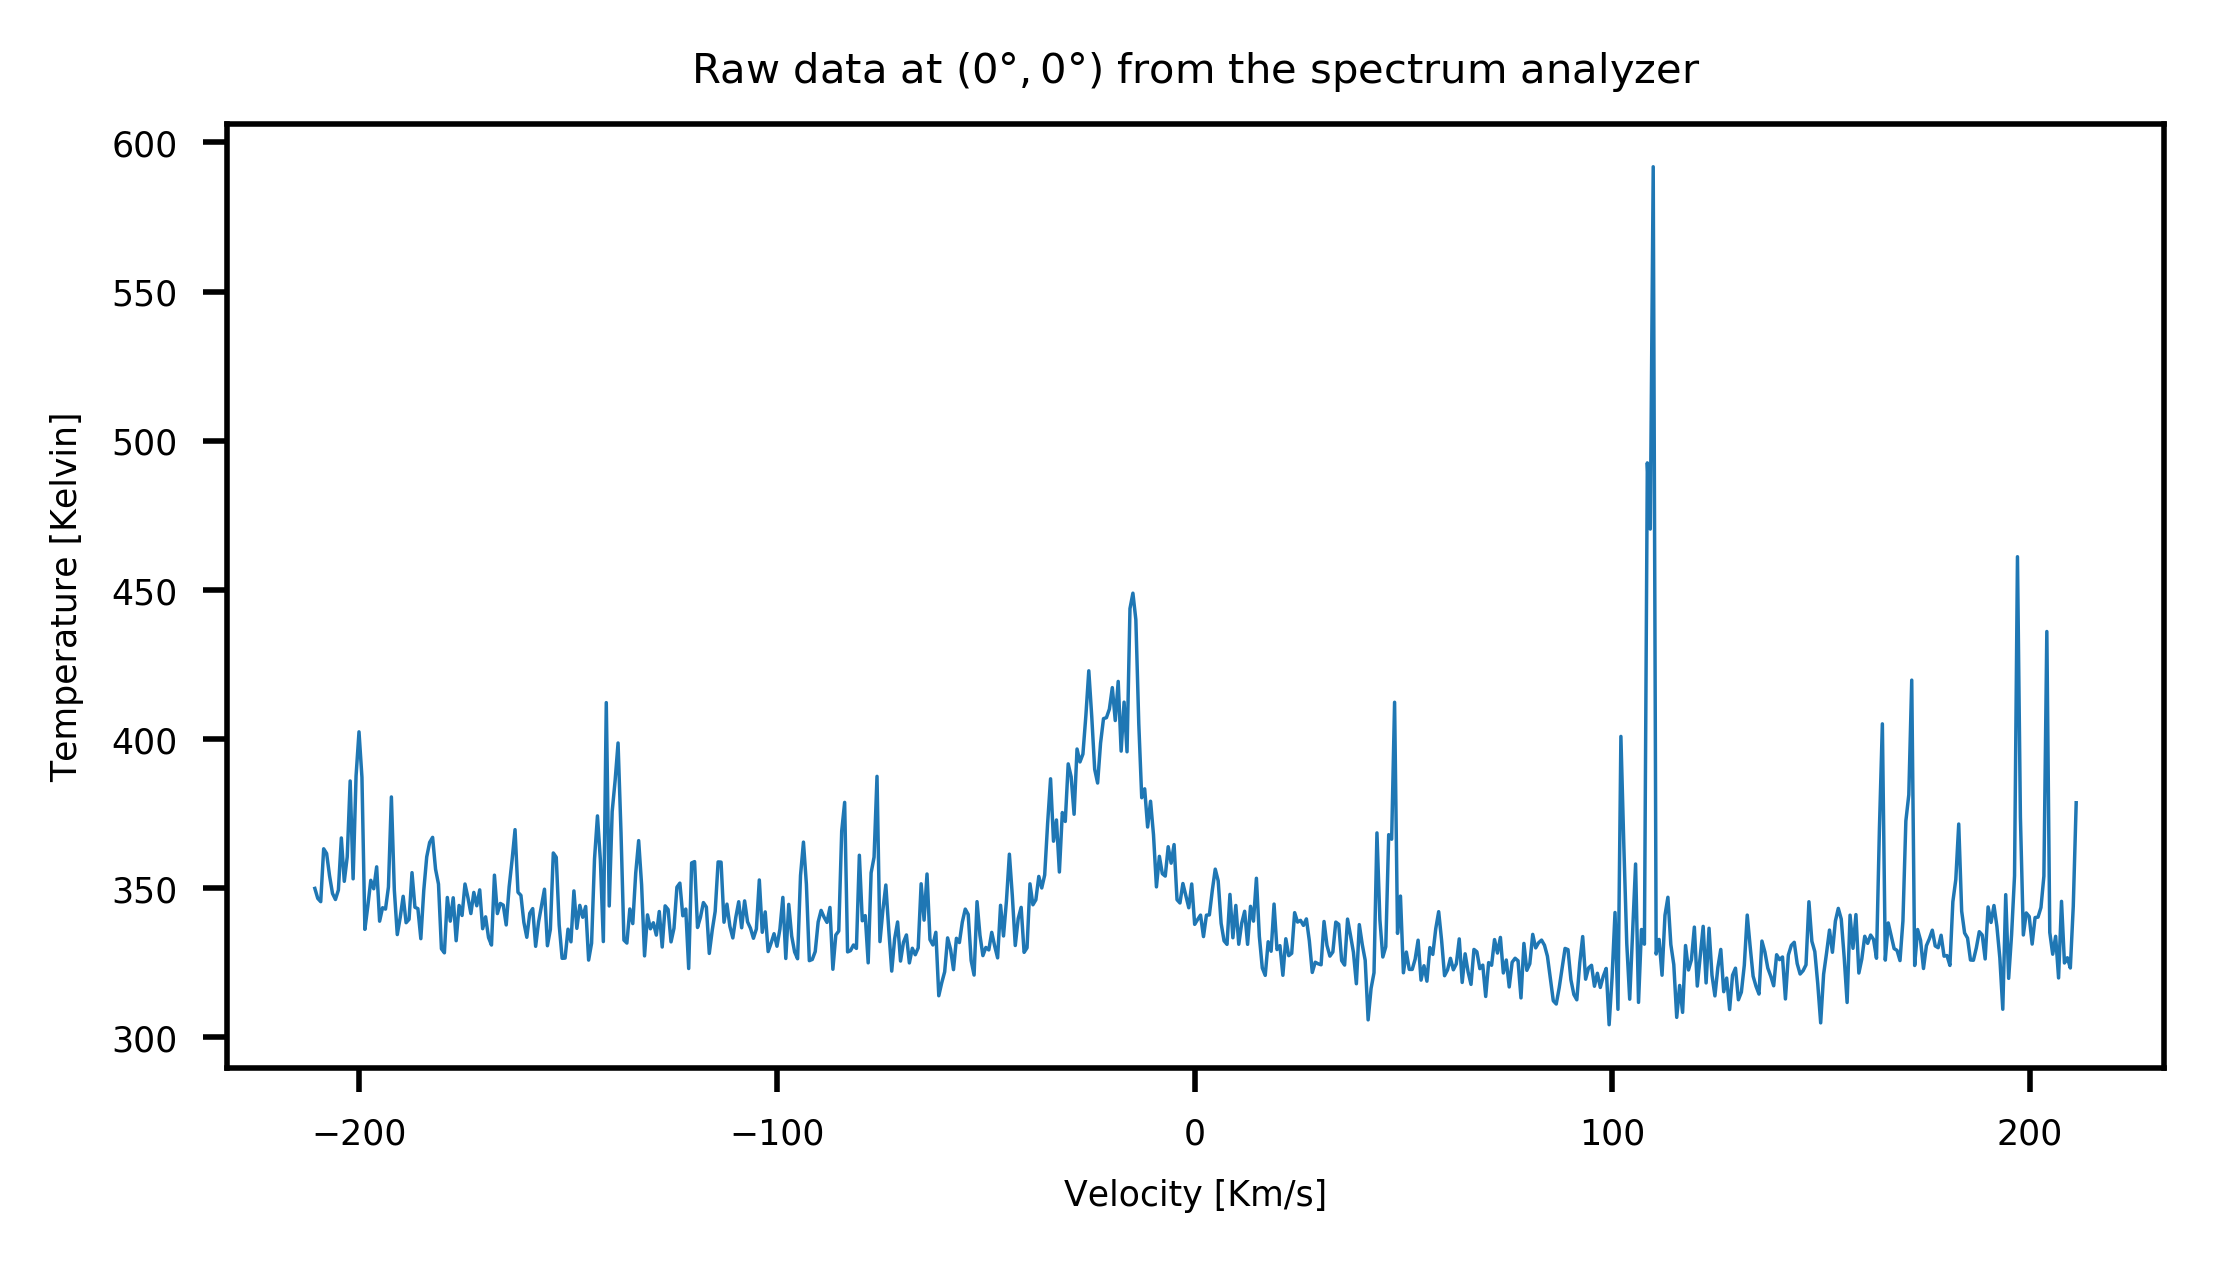

In [77]:
#plot sample yP
new_vT()
plt.plot(xv[0,:],yP[0,:])
add_vTlabel()
plt.title("Raw data at $(0\degree,0\degree)$ from the spectrum analyzer")
plt.savefig("../img/raw.png")

In [53]:
#delete sharp peaks
ymax=5.25
mult=1.10

start=3
end=length-3


def del_peak(yP_vector):
    yP=np.copy(yP_vector)
    for i in np.arange(start,end):
        ytmp=yP[i]
        ytmpM=yP[i-2]
        ytmpP=yP[i+2]
        yavg=(ytmpM+ytmpP)/2.0
        if ytmp < (mult*yavg):
            pass
        else:
            yP[i]=yavg
            yP[i-1]=yavg
            yP[i+1]=yavg
#     print(np.all(yP==yP_vector))
    return(yP)

In [54]:
def test_del_peak():
    for i in range(180):
        yP_vector=yP[i,:]
        diff=yP_vector-del_peak(yP_vector)
        if np.sum(diff)!=0:
            print("it's working")
            break
                
test_del_peak()

it's working


In [55]:
yP_no_peak=np.apply_along_axis(del_peak,1,yP)

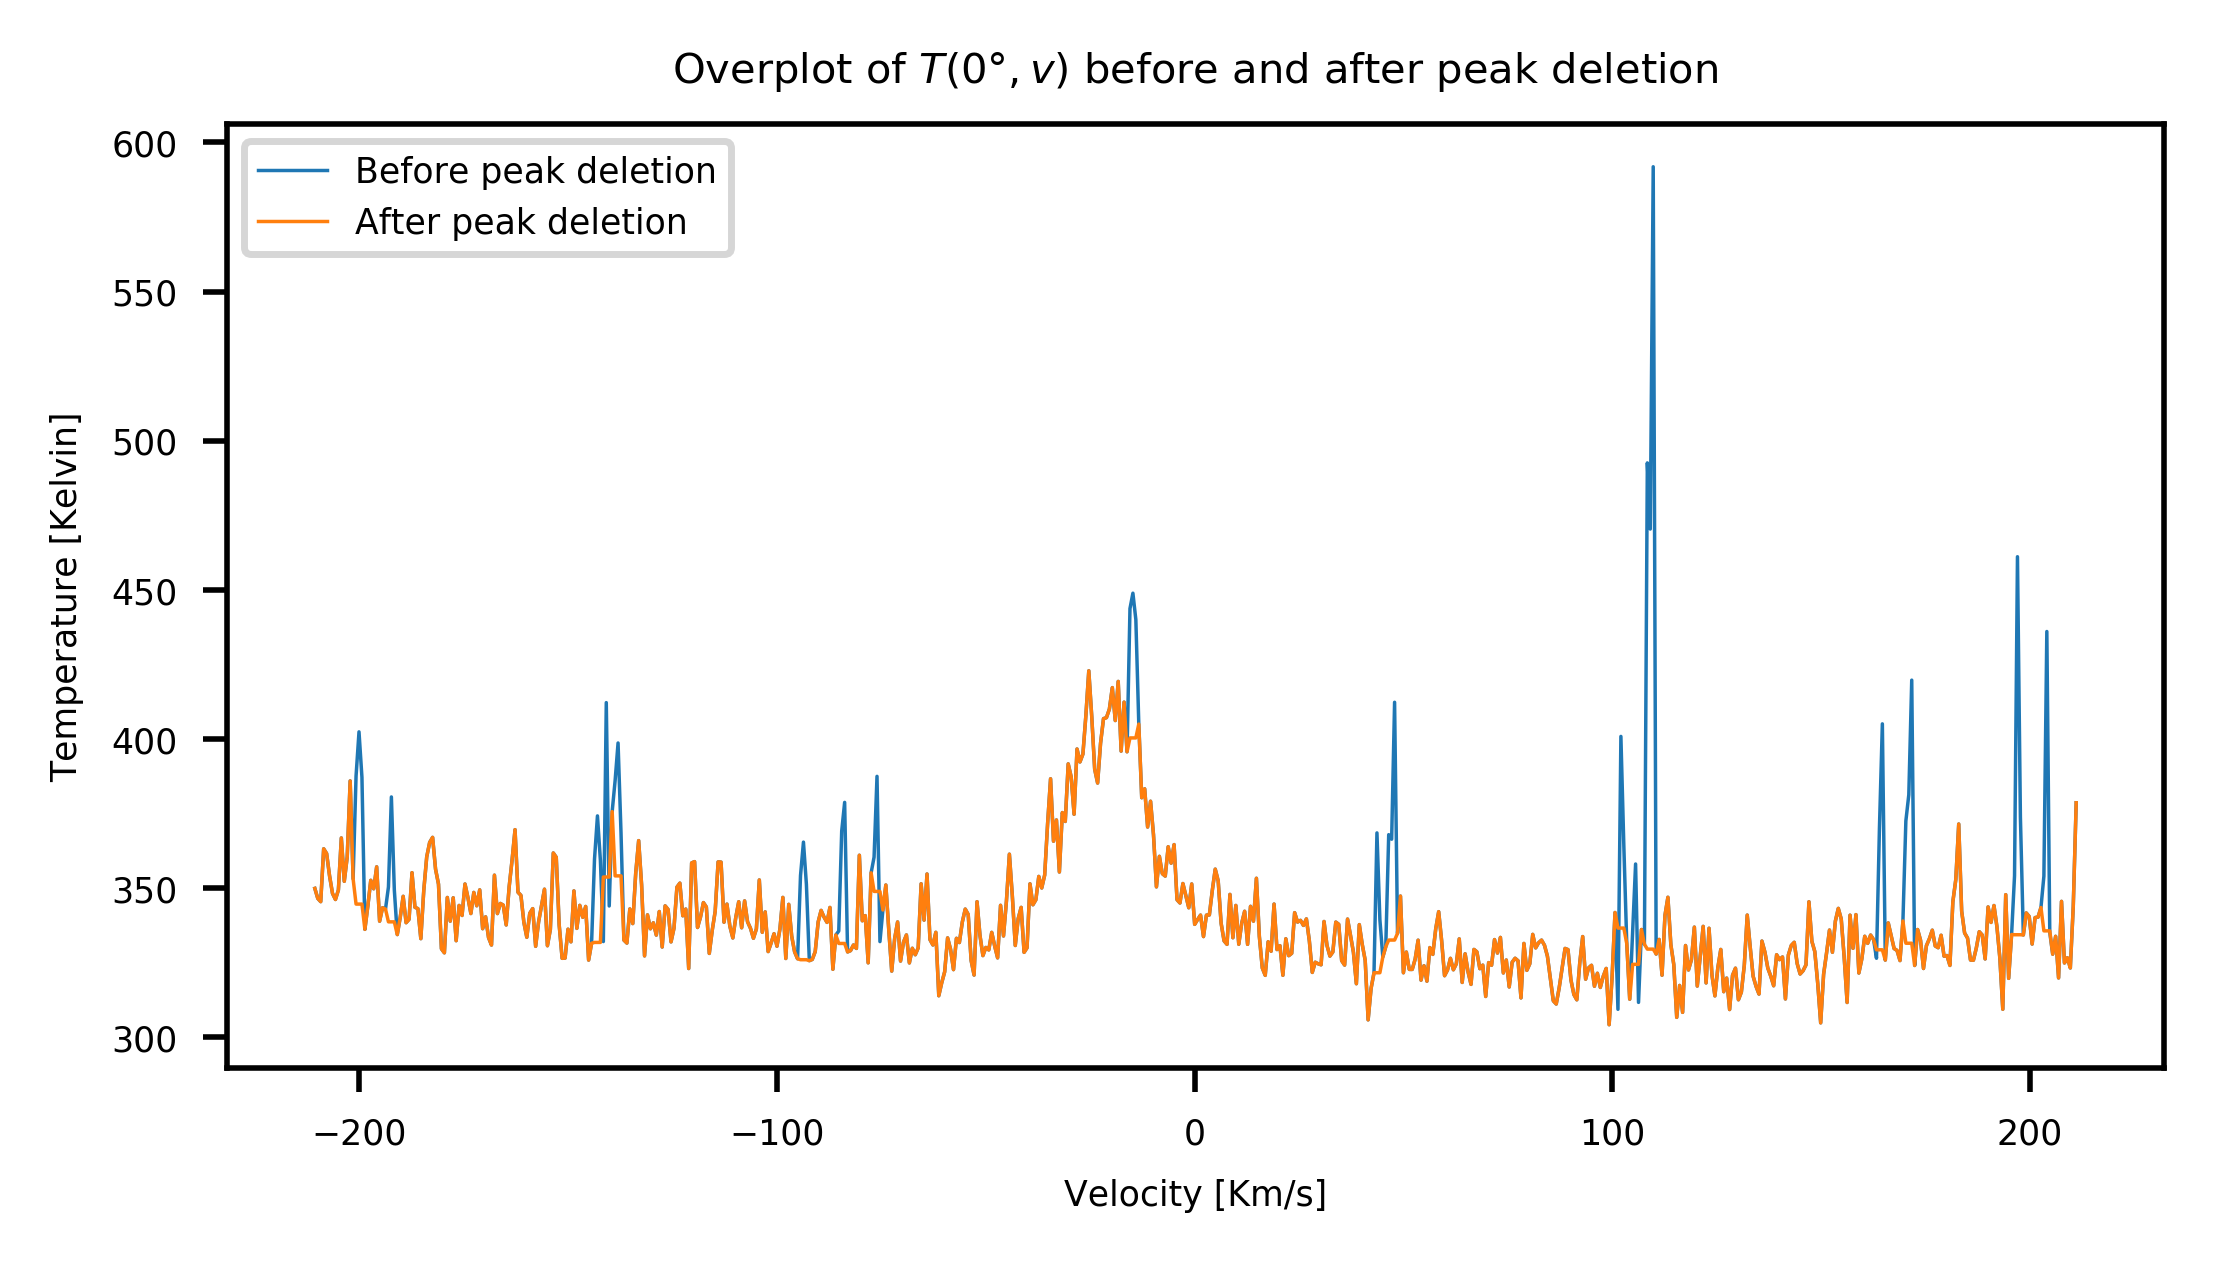

In [57]:
new_vT()
plt.plot(xv[0],yP[0],label="Before peak deletion")
plt.plot(xv[0],yP_no_peak[0],label="After peak deletion")
plt.title("Overplot of $T(0\degree,v)$ before and after peak deletion")
plt.legend(loc=2)
add_vTlabel()
plt.savefig("../img/peak_deletion.png")

In [58]:
#delete the signal region and fit the spectrum with second degree polynomial.
def del_signal_and_fit(xv_vec,yP_vec,del_region=(-50,50)):
    x1del=del_region[0]
    x2del=del_region[1]
    xv=np.copy(xv_vec)
    yP_for_fit=np.copy(yP_vec)
    yP_original=np.copy(yP_vec)
    
    signal_region=(xv>x1del) &(xv<x2del)
    yP_for_fit[signal_region] = np.mean(yP_for_fit[~signal_region])
    
    z=np.polyfit(xv,yP_for_fit,2)
    p=np.poly1d(z)
#     print(yP)
    
#     for i in range(length):
#         xtmp=xv[i]
        
#         if (xtmp > x1del and xtmp < x2del):
#             XB[npoint]=xtmp
#             YB[npoint]=
#             npoint=npoint+1
#         else:
#             XB[npoint]=xtmp
#             YB[npoint]=yP[i]
#             npoint=npoint+1

#     plt.plot(xv,yP_for_fit)
#     plt.plot(xv,p(xv))
    fit=p(xv)
    YP=yP_original-fit
#     plt.plot(xv,YP)
    plt.show()
    return(YP)

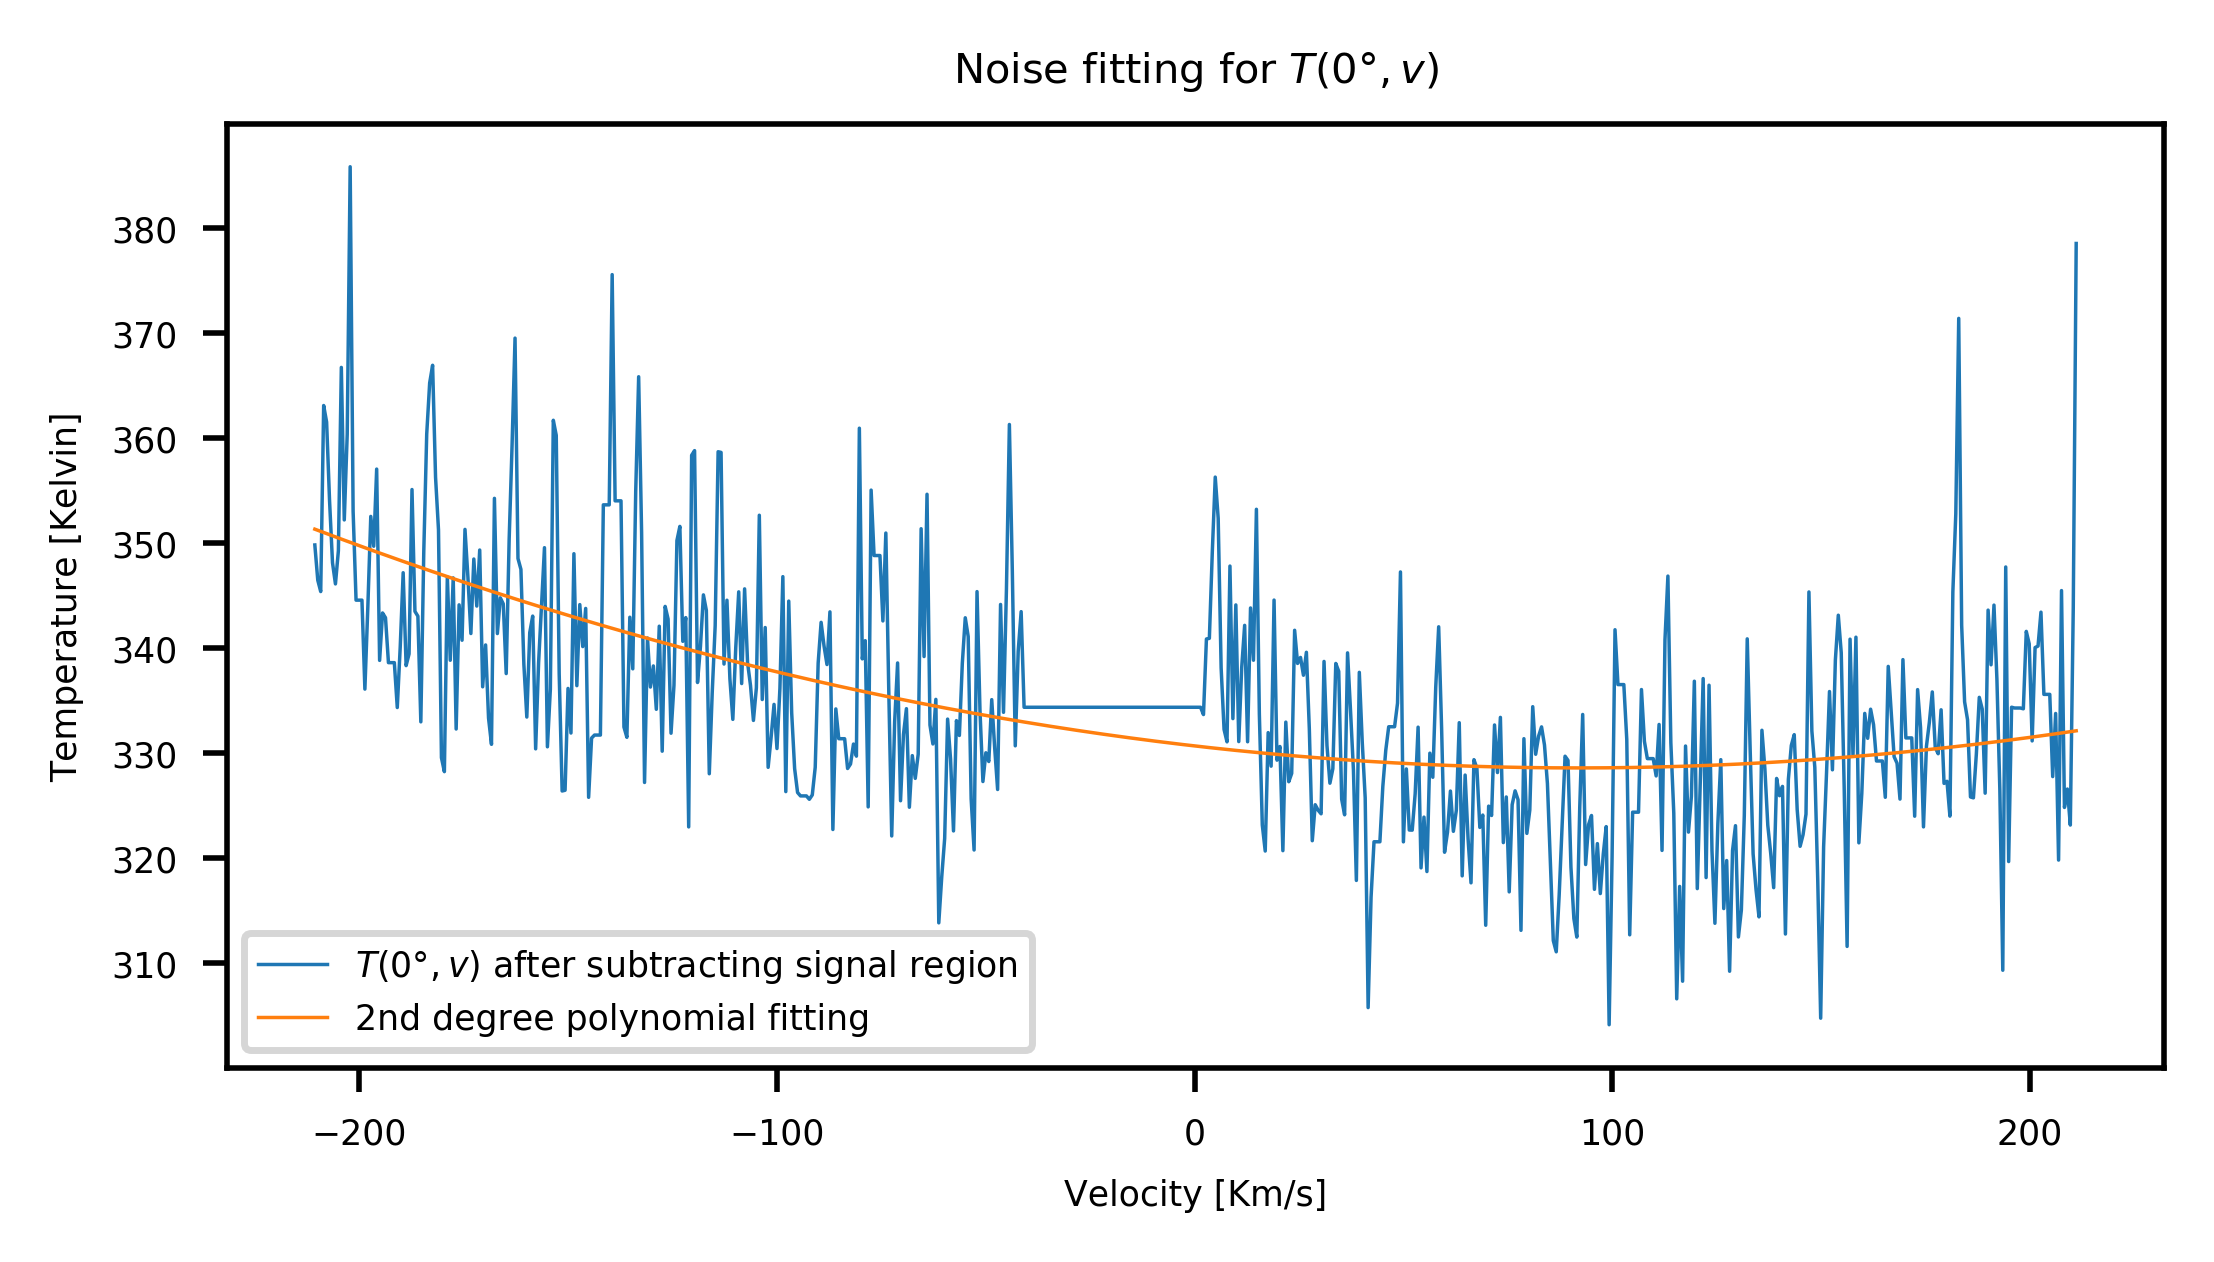

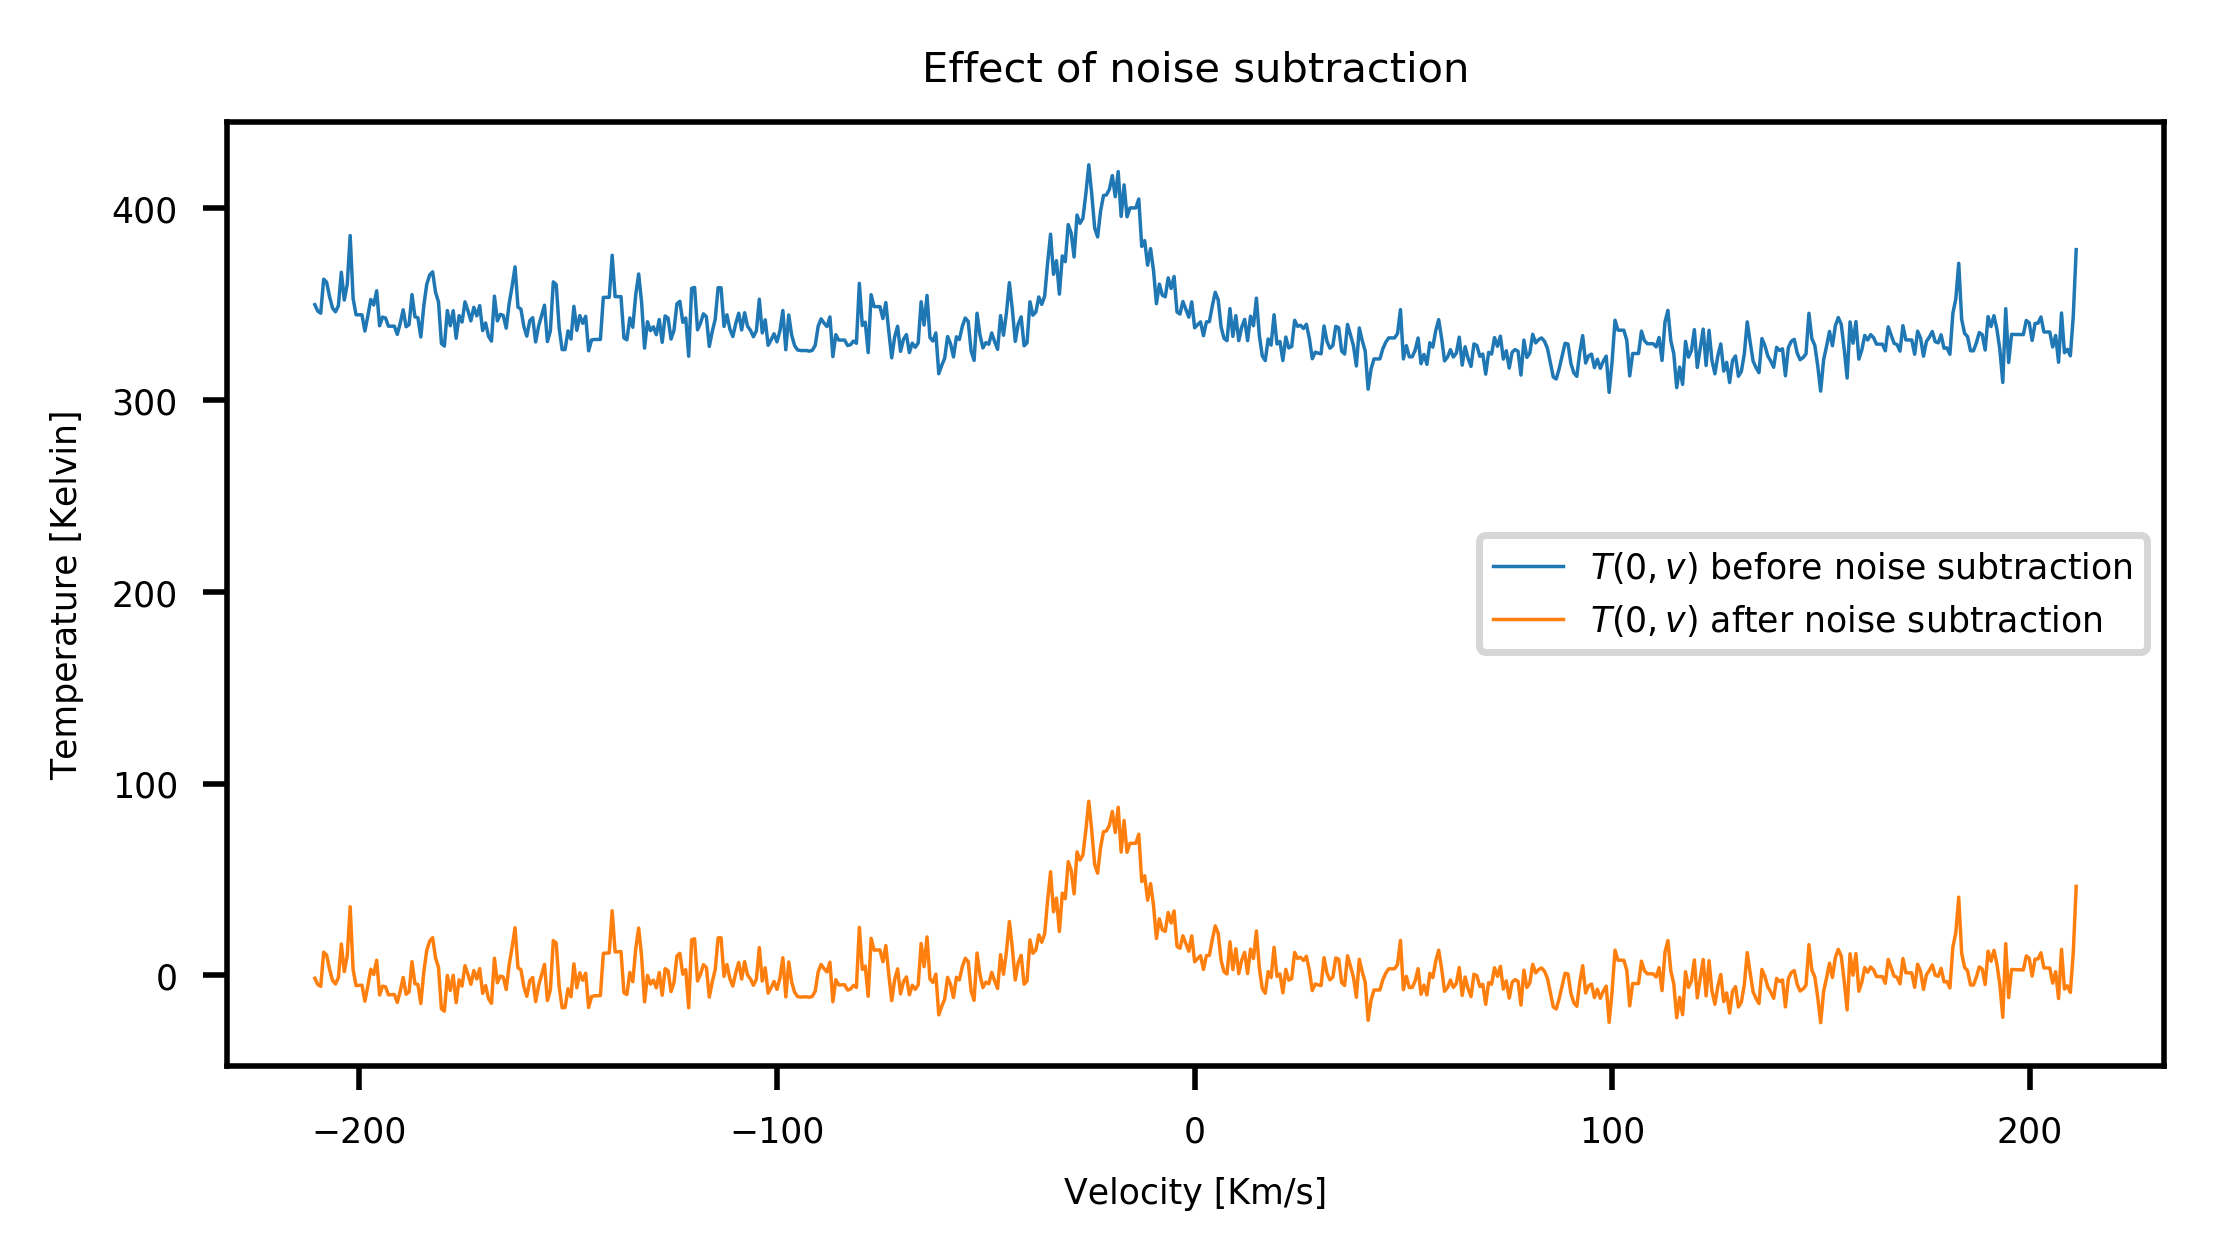

In [59]:
def plot_del_signal_and_fit(xv_vec,yP_vec,del_region=(-50,50)):
    x1del=del_region[0]
    x2del=del_region[1]
    xv=np.copy(xv_vec)
    yP_for_fit=np.copy(yP_vec)
    yP_original=np.copy(yP_vec)
    
    signal_region=(xv>x1del) &(xv<x2del)
    yP_for_fit[signal_region] = np.mean(yP_for_fit[~signal_region])
 
    z=np.polyfit(xv,yP_for_fit,2)
    p=np.poly1d(z)
    

    
    fit=p(xv)
    YP=yP_original-fit
    
    new_vT()
    plt.plot(xv,yP_for_fit,label="$T(0\degree,v)$ after subtracting signal region")
    plt.plot(xv,fit,label="2nd degree polynomial fitting")
    plt.legend() 
    add_vTlabel()
    plt.title("Noise fitting for $T(0\degree,v)$")
    plt.savefig("../img/fitting.png")
    plt.show()
    plt.close()
    
    new_vT()
    plt.plot(xv,yP_original,label="$T(0,v)$ before noise subtraction")
    plt.plot(xv,YP,label="$T(0,v)$ after noise subtraction")
    plt.legend()
    add_vTlabel()
    plt.title("Effect of noise subtraction")
    plt.savefig("../img/noisesub.png")
    return(YP)
test=plot_del_signal_and_fit(xv[0,:],yP_no_peak[0,:],tuple(width[0]))

In [60]:
subtracted_yP=np.empty([90,length])

for i in range(90):
    subtracted_yP[i,:]=del_signal_and_fit(xv[i,:],yP_no_peak[i,:],tuple(width[i]))

In [61]:
def rebinning(xv_vec,yP_vec):
    xv_rebinned=np.empty(int(length/6))
    yP_rebinned=np.empty(int(length/6))
    for i in np.arange(0,length,6):
        xv_rebinned[int(i/6)]=np.mean(xv_vec[i:i+6])
        yP_rebinned[int(i/6)]=np.mean(yP_vec[i:i+6])
    return(xv_rebinned,yP_rebinned)

In [62]:
x,y=rebinning(xv[1,:],subtracted_yP[1,:])

In [63]:
xv_rebinned=np.empty([90,100])
yP_sub_rebinned=np.empty([90,100])
for i in range(90):
    x,y=rebinning(xv[i,:],subtracted_yP[i,:])
    xv_rebinned[i,:]=x
    yP_sub_rebinned[i,:]=y

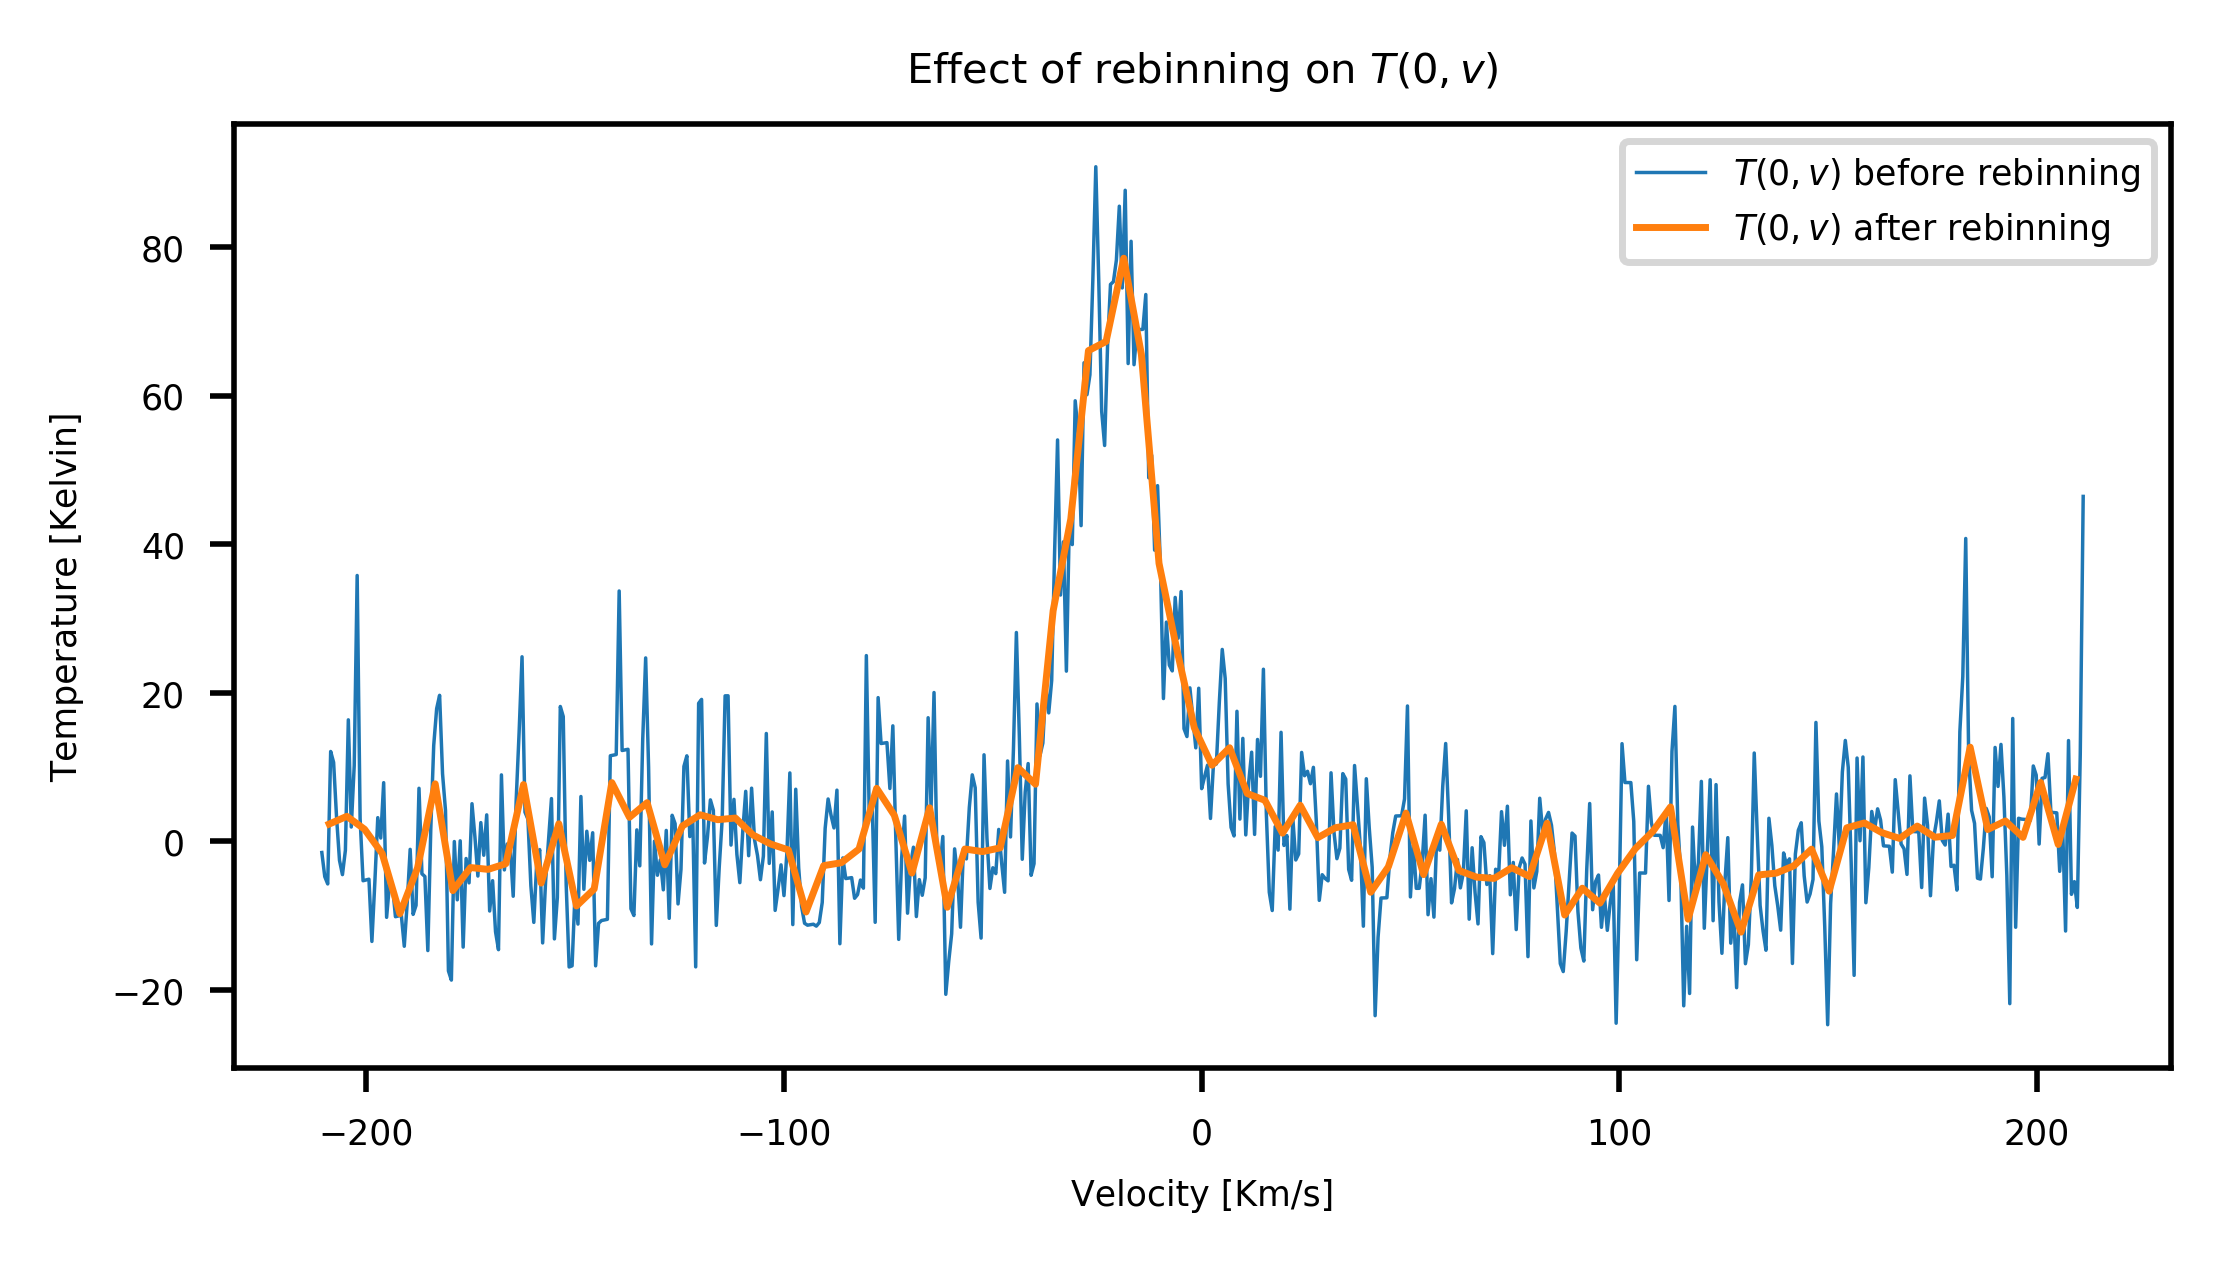

In [64]:
new_vT()
plt.plot(xv[0,:],subtracted_yP[0,:],label="$T(0,v)$ before rebinning")
plt.plot(xv_rebinned[0,:],yP_sub_rebinned[0,:],linewidth=1,label="$T(0,v)$ after rebinning")
plt.title("Effect of rebinning on $T(0,v)$")
add_vTlabel()
plt.legend()
plt.savefig("../img/rebinning.png")
plt.show()


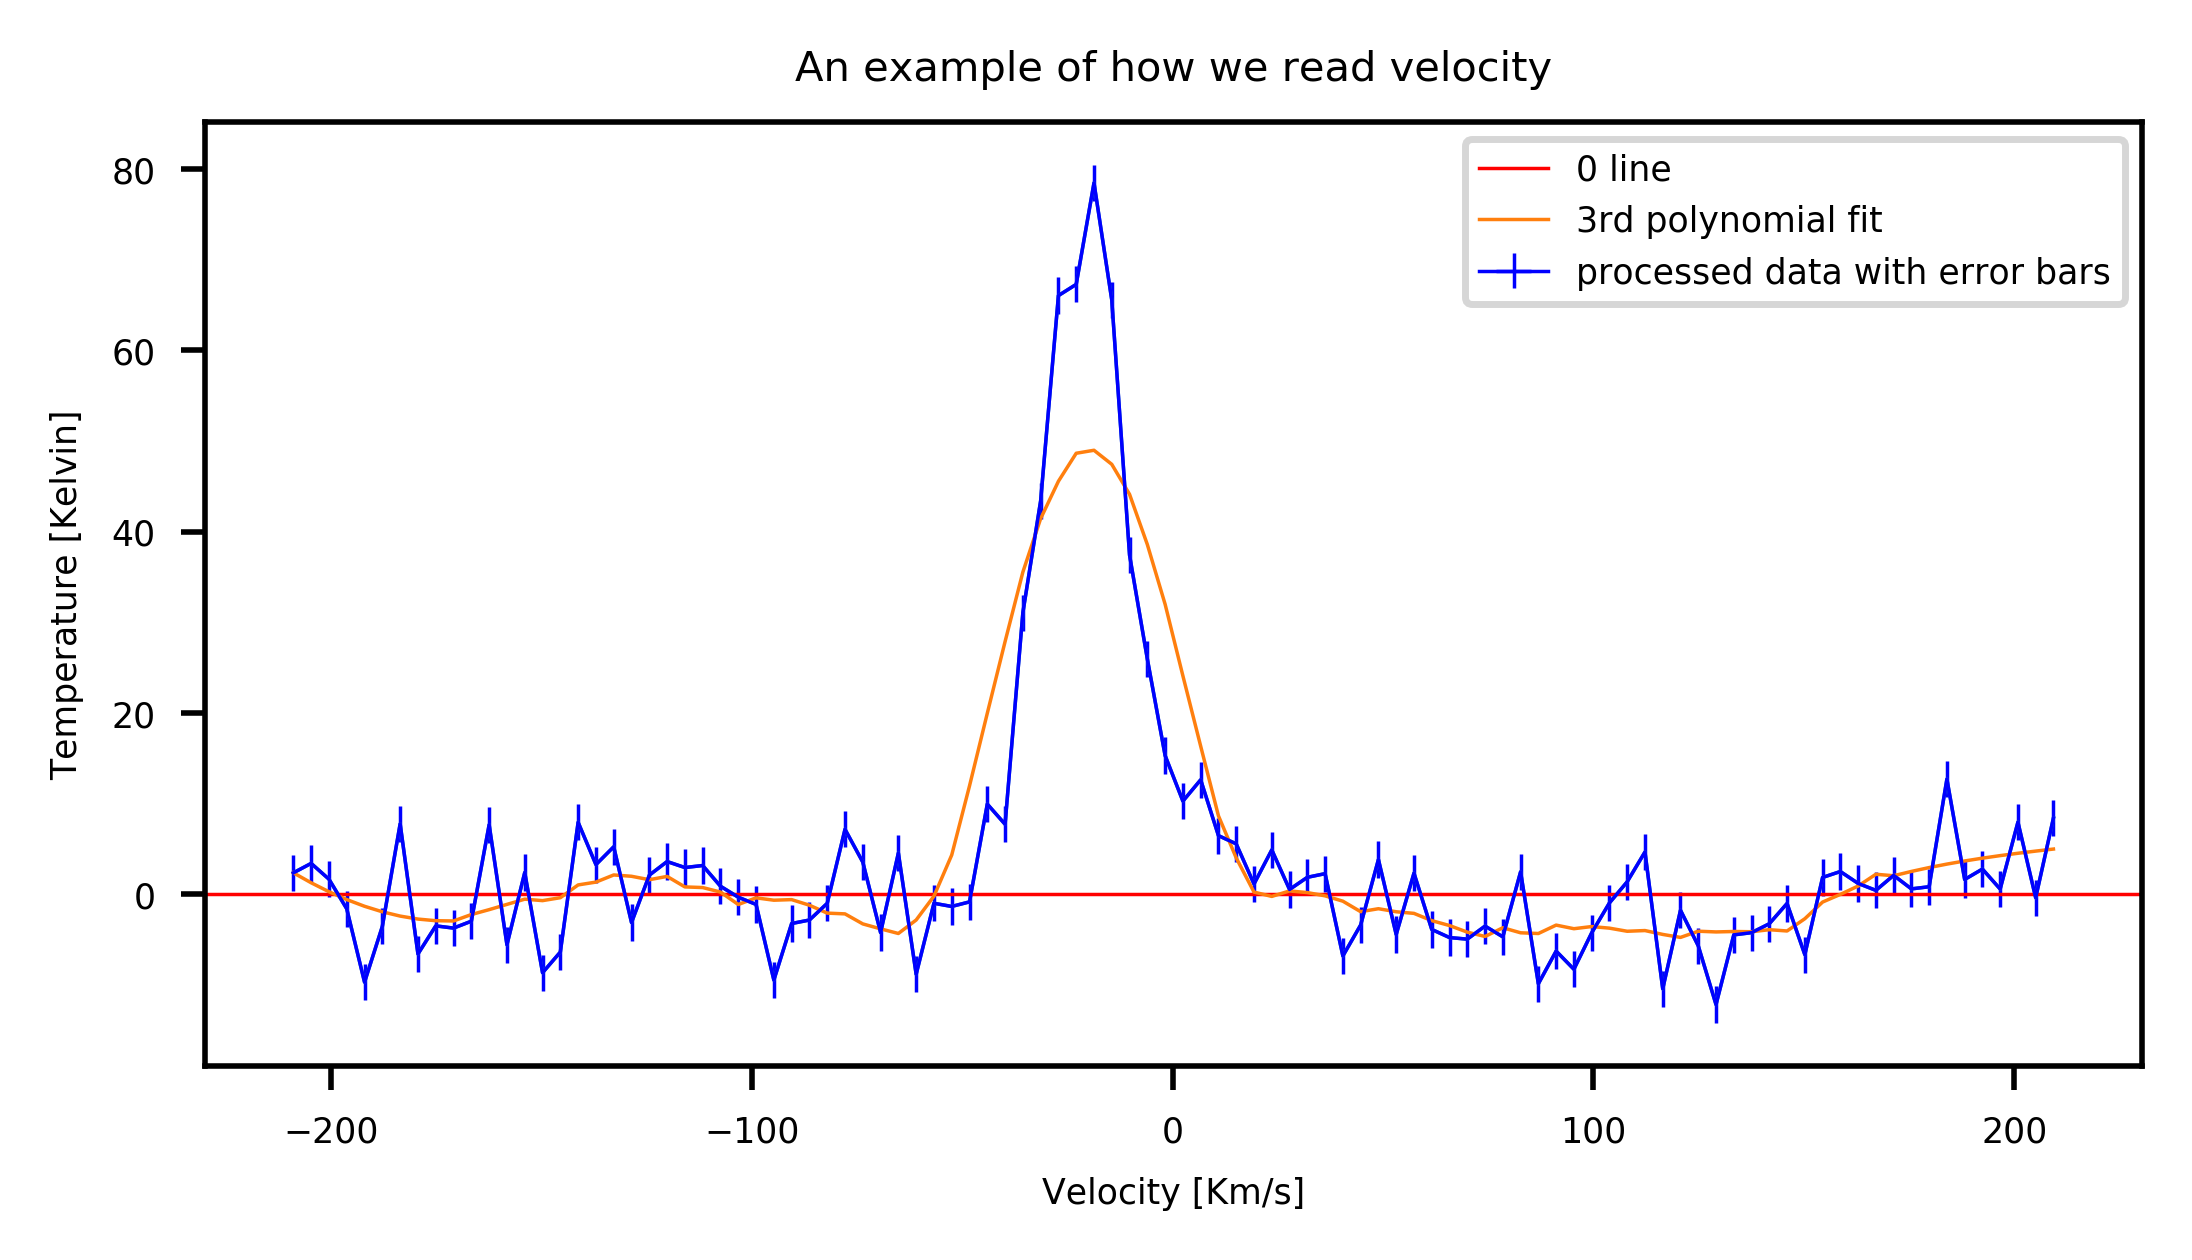

In [110]:
new_vT()
x=xv_rebinned[0,:]
y=yP_sub_rebinned[0,:]
plt.plot(x,y)
yhat=savgol_filter(y,19,3)
plt.axhline(y=0,color='r',label="0 line")
# plt.axvline(x=0,color='r')
plt.plot(x,yhat,label="3rd polynomial fit")
plt.title("An example of how we read velocity")
plt.errorbar(x,y,xerr=np.full(100,0.15),yerr=np.full(100,2.0),color='b', label="processed data with error bars")
plt.legend()
add_vTlabel()
plt.savefig("../img/vel")
plt.show()

In [65]:
speedData= [(-53, 7), (-51, 7), (-52, 8), (-54, 7), (-54, 8), (-54, 6), (-59, 9), (-54, 16), (-67, 12), (-61, 7), (-59, 10), (-61, 10), (-60, 10), (-75, 15), (-65, 15), (-65, 17), (-82, 20), (-65, 10), (-61, 12), (-69, 12), (-65, 15), (-70, 15), (-77, 14), (-89, 19), (-114, 15), (-122, 18), (-112, 15), (-114, 15), (-134, 20), (-114, 17), (-122, 15), (-123, 14), (-128, 17), (-120, 13), (-133, 15), (-113, 10), (-120, 20), (-116, 13), (-105, 7), (-110, 15), (-114, 14), (-124, 20), (-101, 17), (-118, 22), (-92, 20), (-93, 10), (-92, 12), (-90, 10), (-90, 9), (-90, 15), (-88, 7), (-85, 13), (-83, 15), (-78, 10), (-73, 10), (-75, 10), (-70, 12), (-73, 14), (-61, 13), (-57, 10), (-55, 18), (-56, 8), (-48, 13), (-50, 13), (-54, 15), (-40, 15), (-42, 14), (-45, 10), (-37, 10), (-36, 12), (-35, 10), (-31, 12), (-29, 14), (-29, 17), (-29, 10), (-29, 12), (-27, 9), (-27, 10), (-29, 10), (-27, 15), (-25, 5), (-25, 8), (-24, 8), (-22, 8), (-22, 12), (-18, 10), (-21, 10), (-18, 10), (-19, 15), (-13, 10)]
len(speedData)
np.save('speedData0to90', speedData)

In [79]:
redshift = np.load('earth_redshift.npy').flatten()
redshiftA = redshift[180:270]

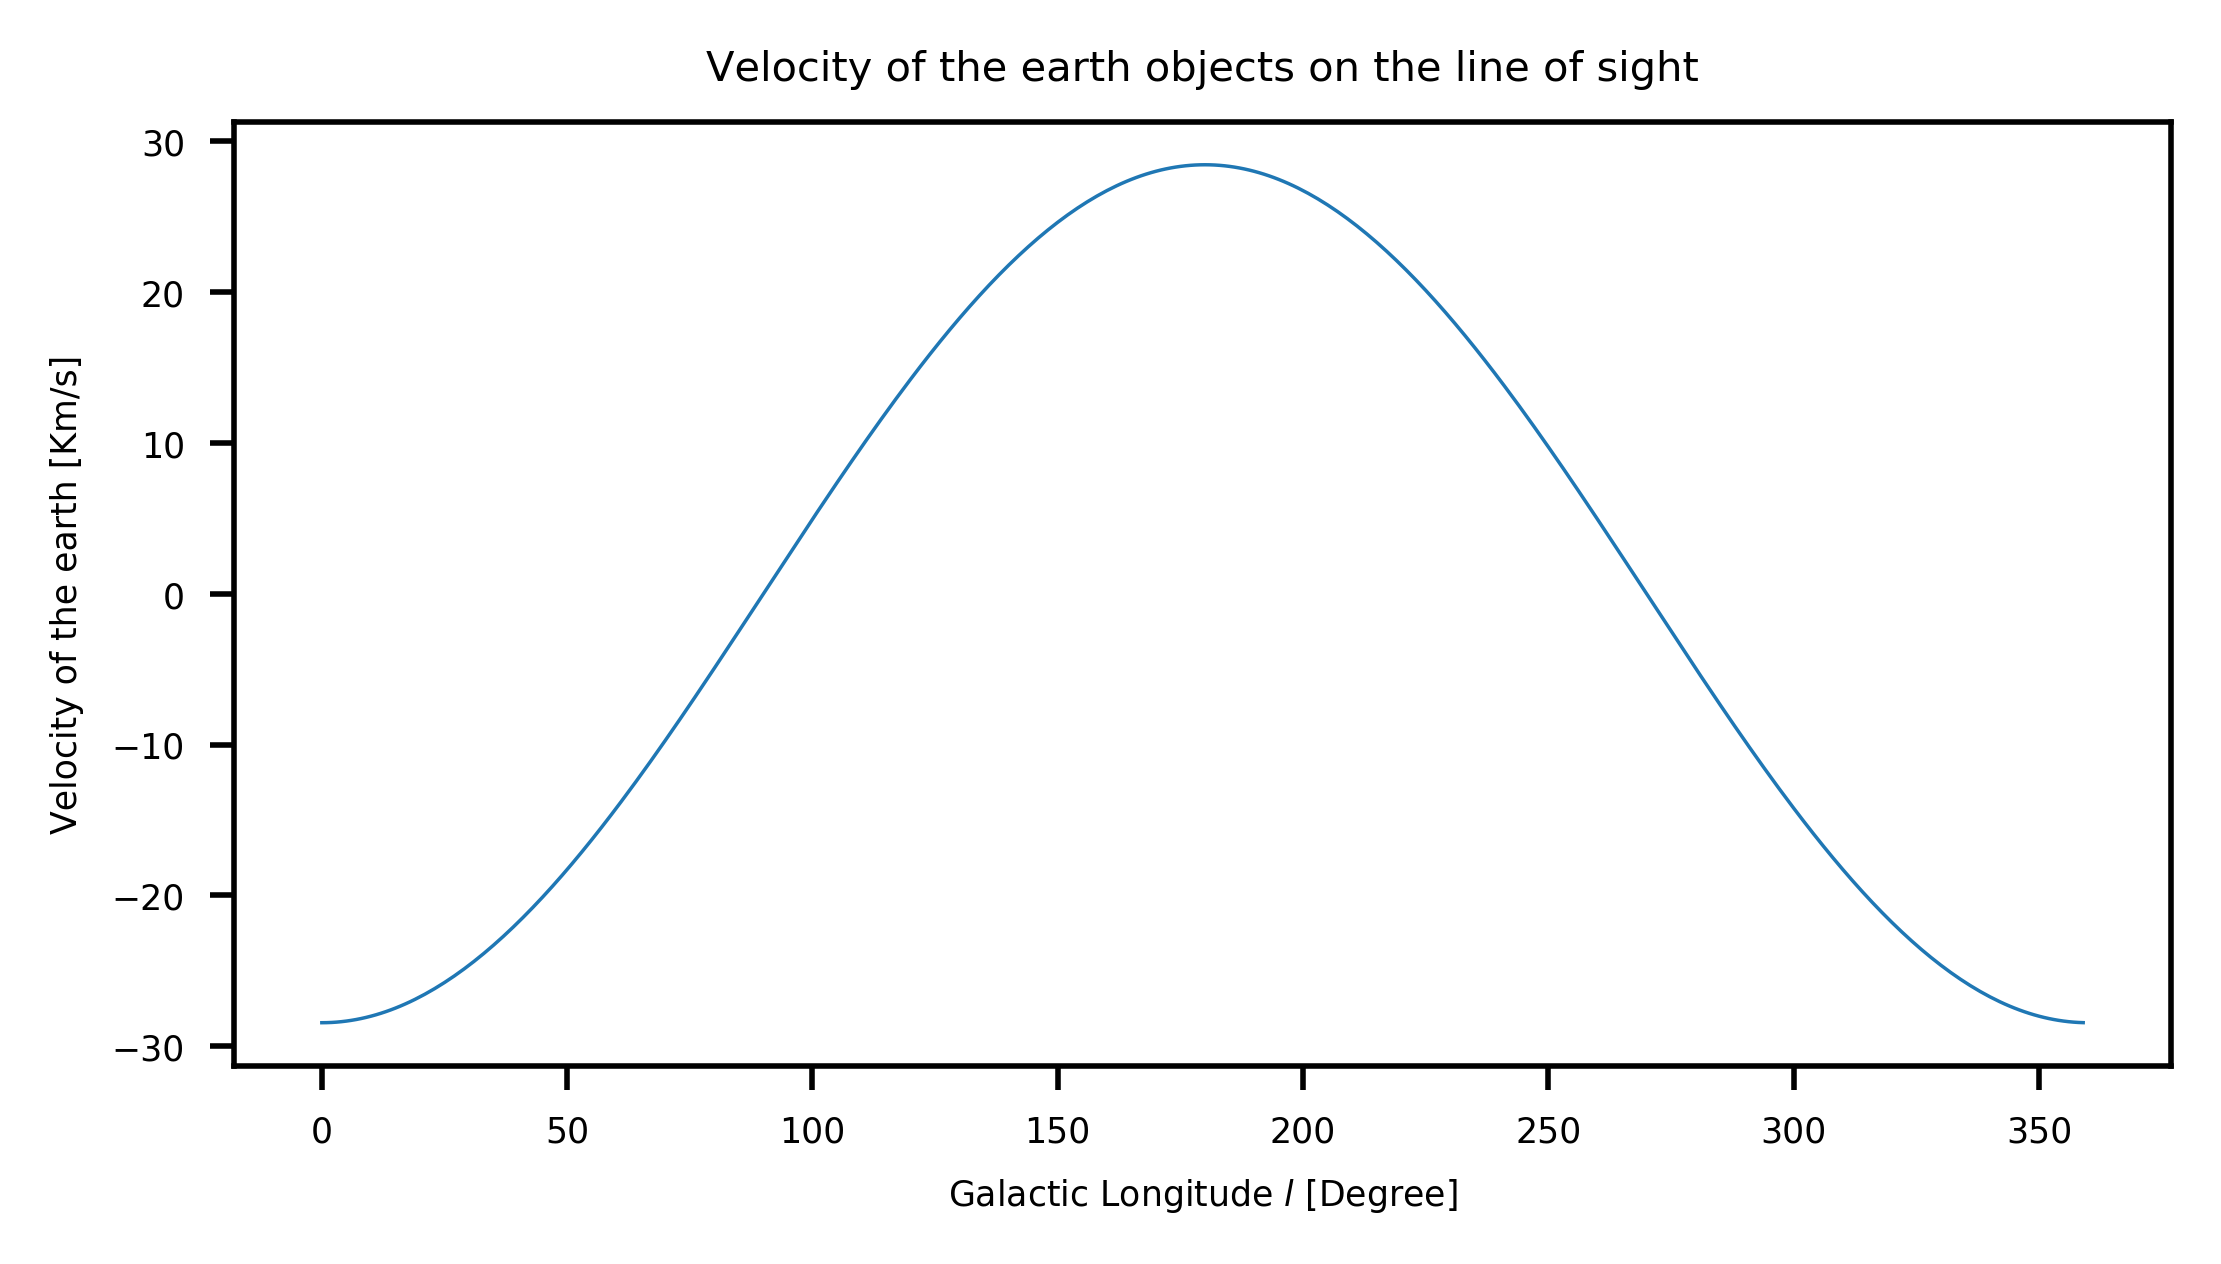

In [80]:
new_vT()
x=plt.np.arange(0,360,1)
y=redshift
plt.plot(x,y)
plt.xlabel("Galactic Longitude $l$ [Degree]")
plt.ylabel("Velocity of the earth [Km/s]")
plt.title("Velocity of the earth objects on the line of sight")
plt.savefig("../img/earth.png")
plt.show()

/Users/user/anaconda3/envs/darkmatter/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


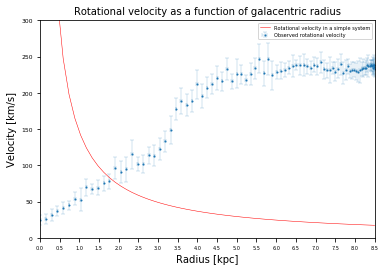

In [139]:
## ANALYZE SPEED DATA TO MAKE G CURVE

dR = (8.2*1000)*np.cos(long)*(.0026)#**2


speed_array =[]
error_array =[]
long = np.arange(0,90)
for i in range(90):
    speed = -speedData[i][0]
    error = speedData[i][1]
    speed_array.append(speed)
    error_array.append(error)
v_array =[]


vLSR = []
radius = 8.5*np.sin(long*np.pi/180)

# add correction for angular velocity
vCor=[None]*90
for i in range(90):
    vCor[i] =  220*np.sin(i*np.pi/180)
vCor=np.array(vCor)
v_array=np.array(speed_array)+vCor - redshiftA

def lum_velocity(r):
    vel=np.sqrt(G*0.5e7)/r
    vel[0]=500
    return(vel)

plt.figure(1, figsize = (6,4) )
plt.title('Rotational velocity as a function of galacentric radius', fontsize = 10)
plt.xlabel('Radius [kpc]', fontsize = 10)
plt.ylabel('Velocity [km/s]', fontsize = 10)
plt.xticks(np.arange(0,9, step =0.5), fontsize = 5)
plt.yticks(fontsize = 6)
plt.xlim(xmin = 0.0)
plt.plot(radius,lum_velocity(radius),color='r',label="Rotational velocity in a simple system")
plt.ylim(0,300)
plt.errorbar(radius, v_array, yerr = error_array, xerr = dR/1000, fmt='o', linestyle="None", capsize = 2, capthick = .2, elinewidth = .2, ms = 1, label="Observed rotational velocity")
plt.legend()
plt.savefig("../img/grot_compare",dpi=300)
plt.show()


In [132]:
lum_velocity(radius)

/Users/user/anaconda3/envs/darkmatter/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


array([  500.        , 98865.77180194, 49440.41591578, 32968.64633969,
       24735.27601972, 19797.26840512, 16506.94536478, 14158.15974725,
       12397.83852138, 11029.83049023,  9936.44537712,  9042.78977424,
        8298.93511729,  7670.31582606,  7132.24252789,  6666.60999209,
        6259.83958926,  5901.54794172,  5583.65935735,  5299.79854786,
        5044.86553174,  4814.73199379,  4606.02045599,  4415.94105618,
        4242.16913228,  4082.75218661,  3936.03832018,  3800.62057072,
        3675.29317853,  3559.016901  ,  3450.89126445,  3350.13218688,
        3256.05379665,  3168.05355712,  3085.60001658,  3008.22265852,
        2935.50344364,  2867.06972383,  2802.58827517,  2741.76024925,
        2684.316882  ,  2630.01583086,  2578.63803542,  2529.98501648,
        2483.87654364,  2440.14861423,  2398.6516962 ,  2359.24919557,
        2321.81611588,  2286.23788201,  2252.40930565,  2220.23367269,
        2189.62193641,  2160.49200232,  2132.76809291,  2106.38018211,
      

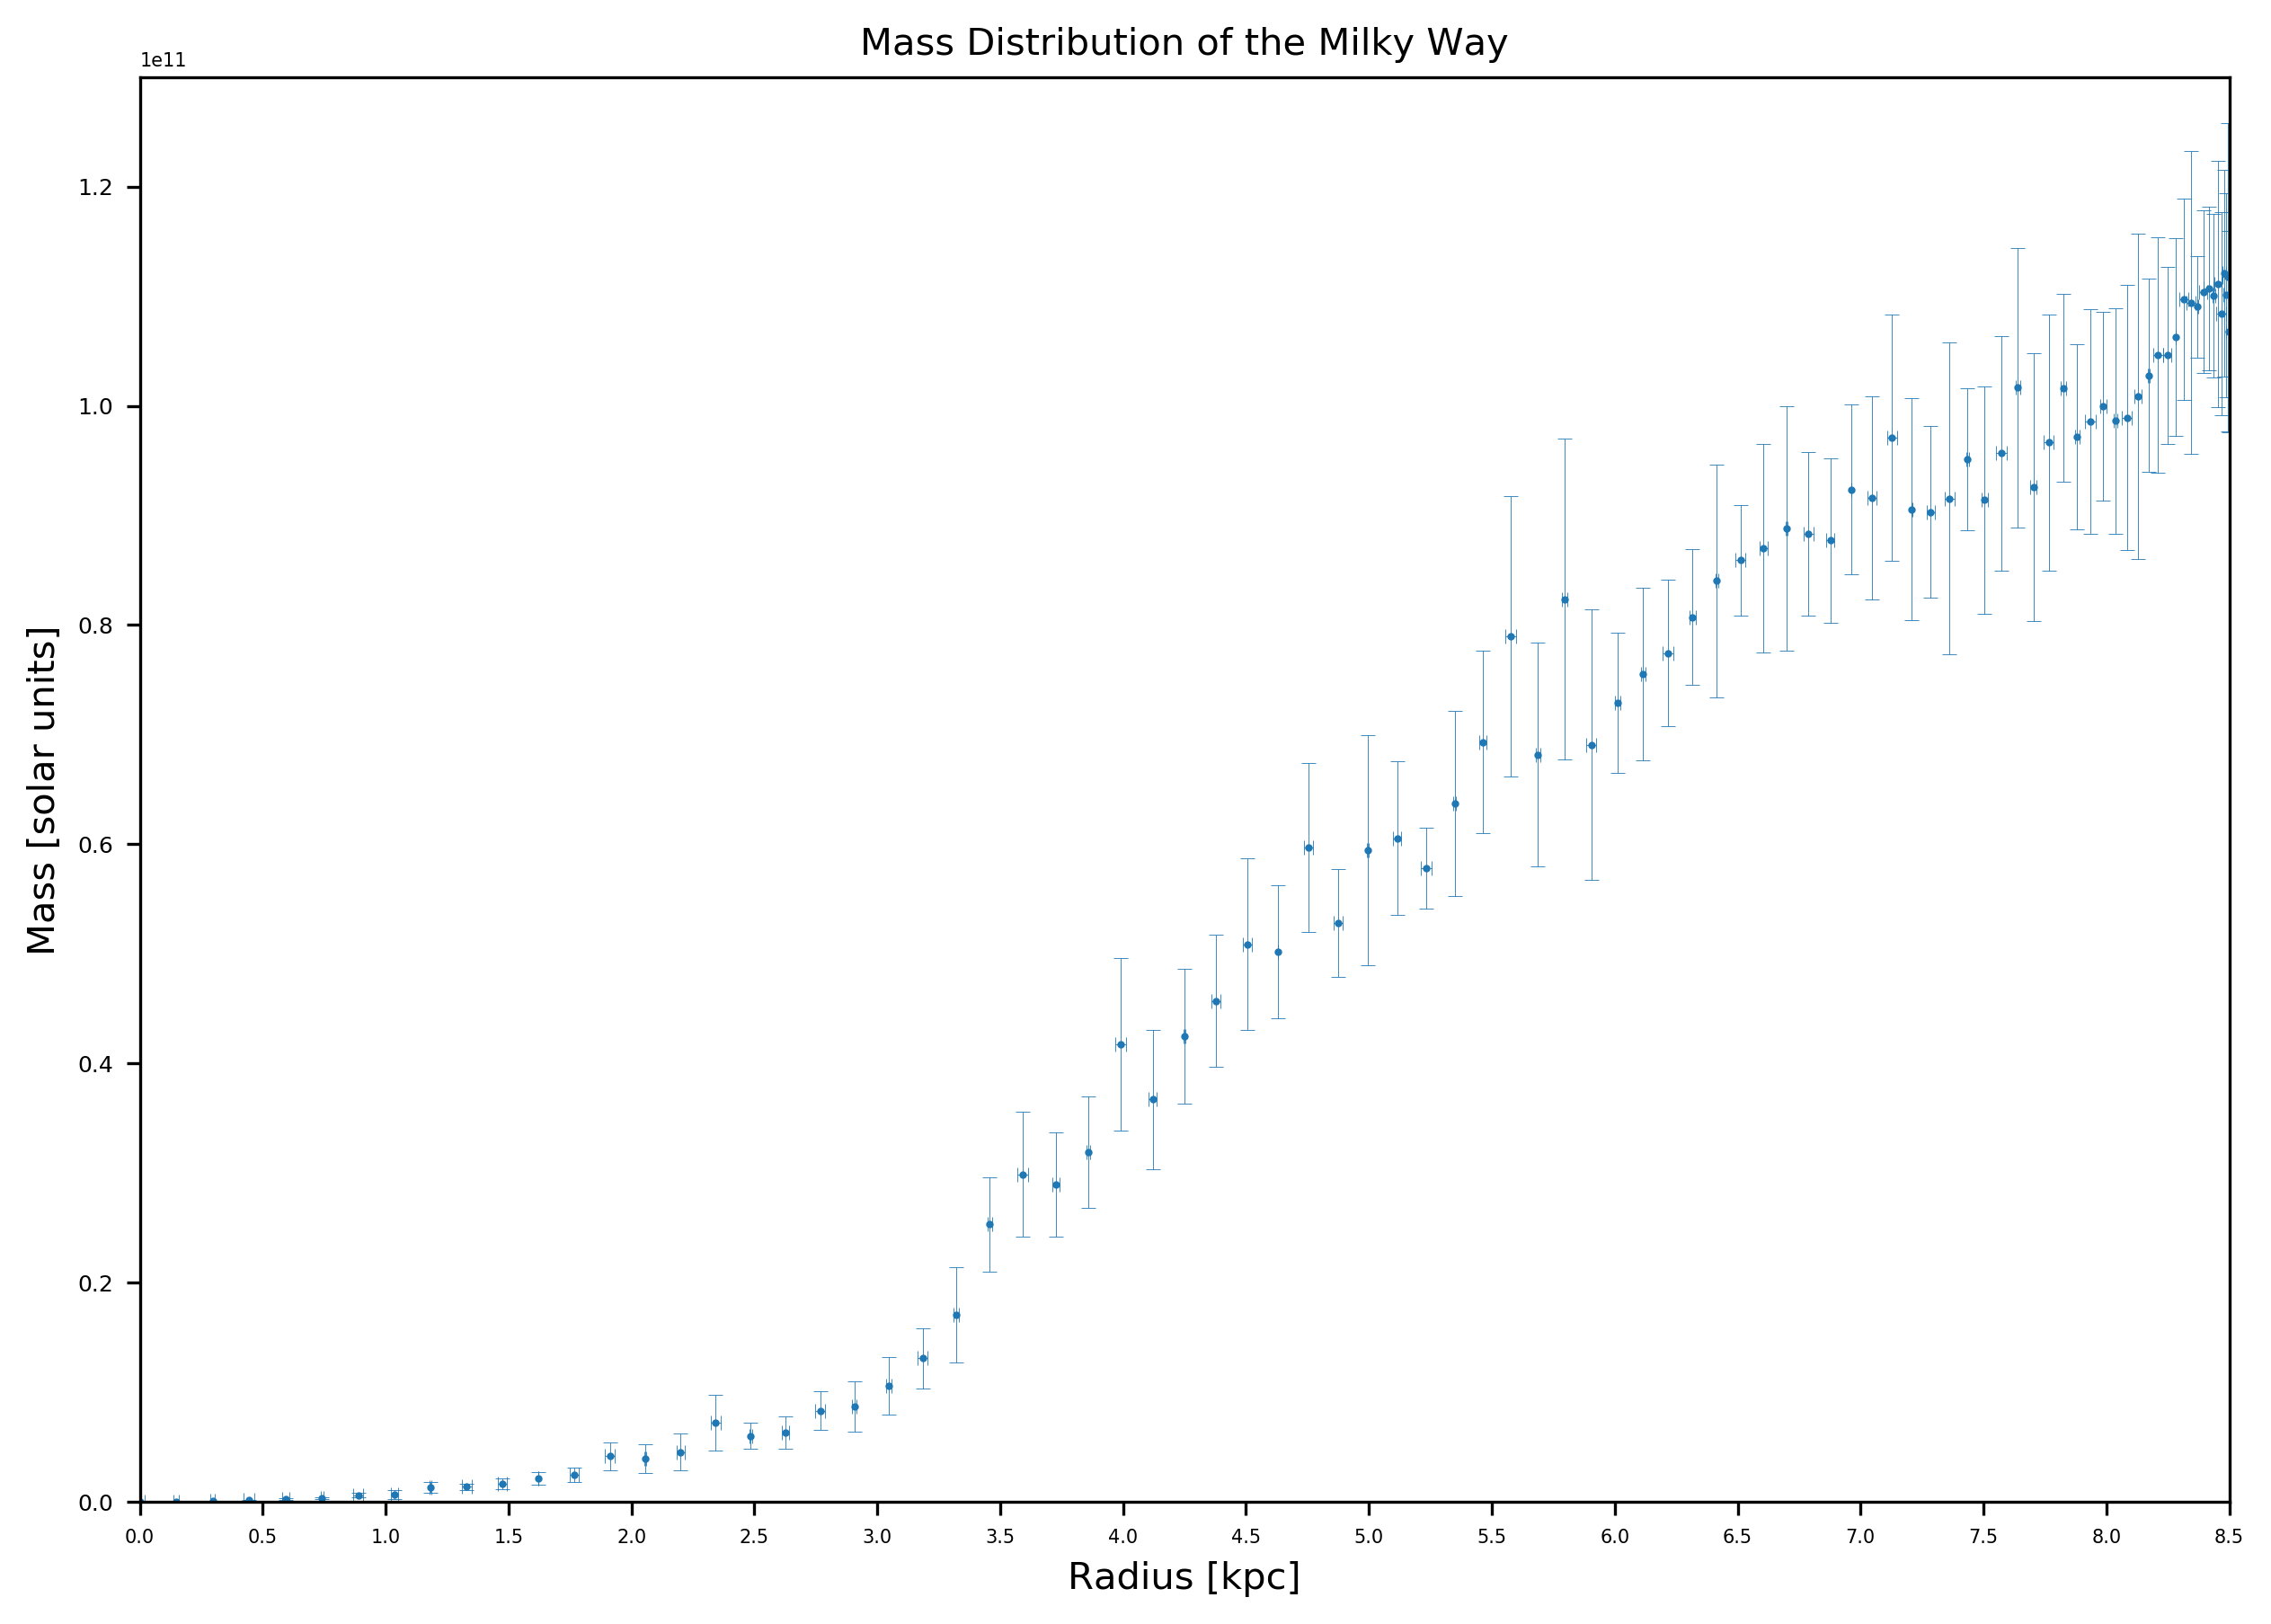

In [119]:
## Error propogation:

G = 4.302e-3 # [pc*solar^-1*(km/s)^2]
dM = np.sqrt(((2*v_array*(radius*1000)/G)*(error_array))**2 + ((v_array**2/G)*dR)**2)

# Mass Distribution
# m = v^2R/G


#Returns mass in solar units 
mass = (v_array**2)*(radius*1000)/G 

plt.figure(1, figsize = (10,7), dpi = 300)
plt.title('Radial mass distribution of the Milky Way', fontsize = 10)
plt.xlabel('Radius [kpc]', fontsize = 10)
plt.ylabel('Mass [solar units]', fontsize = 10)
plt.xticks(np.arange(0,9, step =0.5), fontsize = 5)
plt.yticks(fontsize = 6)
plt.xlim(xmin = 0.0)
plt.ylim(0,1.3e11)
plt.errorbar(radius, mass, yerr = dM, xerr = dR/1000, fmt='o', linestyle="None", capsize = 2, capthick = .2, elinewidth = .2, ms = 1)
plt.savefig("../img/mass")
plt.show()

In [ ]:
## Error propogation:

dR = (8.2)*np.cos(long)*(.0026)**2

dM = np.sqrt(2*v_array*(radius*1000)/G + (v_array**2/G)*dR)